# 1. User Reviews via Steam API (https://partner.steamgames.com/doc/store/getreviews)

In [7]:
# import packages
import os
import sys
import json
import urllib.parse
import urllib.request
import plotly.express as px
from datetime import datetime

import pandas as pd
from pandas import json_normalize


# list package ver. etc.
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
print('---------------')

Python version
3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
Version info.
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)
---------------


---
### Data Dictionary:

- Response:
    - success - 1 if the query was successful
    - query_summary - Returned in the first request
        - recommendationid - The unique id of the recommendation
        - author
            - steamid - the user’s SteamID
            - um_games_owned - number of games owned by the user
            - num_reviews - number of reviews written by the user
            - playtime_forever - lifetime playtime tracked in this app
            - playtime_last_two_weeks - playtime tracked in the past two weeks for this app
            - playtime_at_review - playtime when the review was written
            - last_played - time for when the user last played
        - language - language the user indicated when authoring the review
        - review - text of written review
        - timestamp_created - date the review was created (unix timestamp)
        - timestamp_updated - date the review was last updated (unix timestamp)
        - voted_up - true means it was a positive recommendation
        - votes_up - the number of users that found this review helpful
        - votes_funny - the number of users that found this review funny
        - weighted_vote_score - helpfulness score
        - comment_count - number of comments posted on this review
        - steam_purchase - true if the user purchased the game on Steam
        - received_for_free - true if the user checked a box saying they got the app for free
        - written_during_early_access - true if the user posted this review while the game was in Early Access
        - developer_response - text of the developer response, if any
        - timestamp_dev_responded - Unix timestamp of when the developer responded, if applicable

---
Source: https://partner.steamgames.com/doc/store/getreviews

In [8]:
# generate game review df

#steam 'chunks' their json files (the game reviews) in sets of 100
#ending with a signature, a 'cursor'. This cursor is then pasted
#onto the the same url, to 'grab' the next chunk and so on. 
#This sequence block with an 'end cursor' of 'AoJ4tey90tECcbOXSw=='

#set variables
url_base = 'https://store.steampowered.com/appreviews/393380?json=1&filter=updated&review_type=all&num_per_page=100&cursor='

#first pass
url = urllib.request.urlopen("https://store.steampowered.com/appreviews/393380?json=1&filter=updated&review_type=all&num_per_page=100&cursor=*")
data = json.loads(url.read().decode())
next_cursor = data['cursor']
next_cursor = next_cursor.replace('+', '%2B')
df1 = json_normalize(data['reviews'])
print(next_cursor)

#add results till stopcursor met, then send all results to csv
while True:
    url_temp = url_base + next_cursor
    url = urllib.request.urlopen(url_temp)
    data = json.loads(url.read().decode())
    next_cursor = data['cursor']
    next_cursor = next_cursor.replace('+', '%2B')
    df2 = json_normalize(data['reviews'])
    df1 = pd.concat([df1, df2])
    print(next_cursor)
    if next_cursor == 'AoJ4tey90tECcbOXSw==' or next_cursor == '*':
        df_steam_reviews = df1
        df1 = None
        break
        
#the hash below is each 'cursor' I loop through until the 'end cursor'.
#this is just my way to monitor the data download.

AoJ44emJ1/ICd5zmjQI=
AoJwgqnDzPICdaeIjQI=
AoJ4w4jCwvICd6aojAI=
AoJwiPLjufICcebaiwI=
AoJwp6fcsPICcPGEiwI=
AoJ43%2BC4qPICdsGyigI=
AoJwqObpoPICcPLfiQI=
AoJ4kY6MmfICfamDiQI=
AoJw%2BaeokPICe%2BekiAI=
AoJ47faaivICcqXchwI=
AoJ4/I%2Bmg/ICcbqvzQE=
AoJwoujS/vECf6/khgI=
AoJwnNqT%2BfECcbiqhgI=
AoJw7MfO9/ECdoSYhgI=
AoJwztz99PECf437hQI=
AoJ4z7iG7/ECc4i4hQI=
AoJw2qWs6/ECf%2BC/xAE=
AoJ4xOOD5/ECfNHXhAI=
AoJ4iNGE3fECdLDjgwI=
AoJw24T30fECdJrlggI=
AoJwna6JxfECe8vJgQI=
AoJ4zo%2BXu/ECcdPMgAI=
AoJ45YbtsfECdMW1fA==
AoJwpe%2BQpPECdYmb/gE=
AoJ4tLialvECeMW6/AE=
AoJwxu6rjPECfa2q%2BwE=
AoJw38ChgfECe6HergE=
AoJwju6e8vACeoTJ%2BAE=
AoJw8t2I5fACfc259wE=
AoJ42NiE0/ACcKmJ9gE=
AoJ4%2BurAxfACcvKD9QE=
AoJ47pa0t/ACea788wE=
AoJwmfreqPACe6Pn8gE=
AoJwu9mrm/ACcoHa8QE=
AoJw4KPPj/ACeejZ8AE=
AoJw%2Bpm0gfACcKbS7wE=
AoJwhqSA9e8Cd7GfygE=
AoJ4lKWj6%2B8CdtHa7QE=
AoJwoO2I4O8CcPL37AE=
AoJ4yris1u8CfZKZ7AE=
AoJ49sn0ze8CddrQ6wE=
AoJw1rrkxe8CcIv36gE=
AoJwkIOtu%2B8Cfe2M6gE=
AoJwsI6Ztu8Cd6HH6QE=
AoJw5IrssO8Cdb%2B4lgE=
AoJ4x9j/qe8CeuHbvQE=
AoJw

In [9]:
# convert Unix timestamp columns to datetime format
def time_to_clean(x):
    return datetime.fromtimestamp(x)

df_steam_reviews['timestamp_created'] = df_steam_reviews['timestamp_created'].apply(time_to_clean)
df_steam_reviews['timestamp_updated'] = df_steam_reviews['timestamp_updated'].apply(time_to_clean)
df_steam_reviews['author.last_played'] = df_steam_reviews['author.last_played'].apply(time_to_clean)

In [10]:
# inspect columns
print(df_steam_reviews.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23296 entries, 0 to 95
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   recommendationid                23296 non-null  object        
 1   language                        23296 non-null  object        
 2   review                          23296 non-null  object        
 3   timestamp_created               23296 non-null  datetime64[ns]
 4   timestamp_updated               23296 non-null  datetime64[ns]
 5   voted_up                        23296 non-null  bool          
 6   votes_up                        23296 non-null  int64         
 7   votes_funny                     23296 non-null  int64         
 8   weighted_vote_score             23296 non-null  object        
 9   comment_count                   23296 non-null  int64         
 10  steam_purchase                  23296 non-null  bool          
 11  recei

In [11]:
# inspect shape
print(df_steam_reviews.shape)

(23296, 21)


In [12]:
# inspect df
df_steam_reviews

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.last_played,timestamp_dev_responded,developer_response
0,70962889,english,ehhhh,2020-06-17 22:18:58,2020-06-17 22:18:58,False,0,0,0,0,...,False,True,76561199004779410,46,11,385,379,2020-06-17 22:27:54,NaN,NaN
1,70962654,english,.,2020-06-17 22:09:19,2020-06-17 22:09:19,True,0,0,0,0,...,False,True,76561198134435766,68,31,564,157,2020-06-17 22:49:24,NaN,NaN
2,70962008,english,You win or lose almost entirely based on your ...,2020-06-17 21:45:26,2020-06-17 21:45:26,True,0,0,0,0,...,False,True,76561198555943968,90,13,921,875,2020-06-17 19:26:44,NaN,NaN
3,70957898,english,yep,2020-06-17 19:11:32,2020-06-17 19:11:32,True,0,0,0.454545468091964722,0,...,False,True,76561198298478422,19,3,812,812,2020-06-17 16:55:18,NaN,NaN
4,70956713,english,If you have an older cpu forget it. Since the ...,2020-06-17 18:28:13,2020-06-17 18:28:13,False,2,0,0.52173912525177002,0,...,False,True,76561198254721329,58,4,14887,16,2020-06-17 18:25:54,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,19709642,english,"I bought this game for my crush , she said she...",2015-12-15 05:02:05,2015-12-15 05:02:05,True,2,0,0.418837696313858032,0,...,False,True,76561198072603036,34,20,68,0,2015-12-15 08:14:19,NaN,NaN
92,19709499,english,Very fun game. still needs lot of work but tha...,2015-12-15 04:51:59,2015-12-15 04:51:59,True,6,0,0.476190477609634399,0,...,False,True,76561198046257490,239,6,593,0,2018-03-23 23:00:23,NaN,NaN
93,19709419,english,gg,2015-12-15 04:44:24,2015-12-15 04:44:24,True,1,0,0.462351411581039429,0,...,False,True,76561198069014794,166,12,4656,0,2018-02-28 16:58:02,NaN,NaN
94,19708974,english,I´ve been following the development for quite ...,2015-12-15 03:57:07,2015-12-15 03:57:07,True,1,0,0.525862038135528564,0,...,False,True,76561198086314142,109,8,4437,0,2020-03-23 15:24:24,NaN,NaN


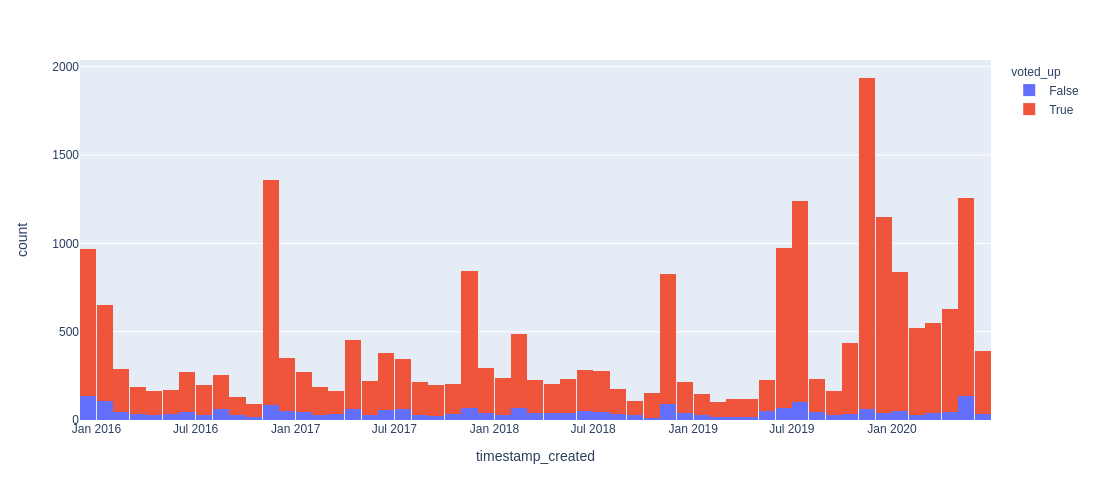

In [16]:
fig = px.histogram(df_steam_reviews, x="timestamp_created", color="voted_up", width=1000, height=500)
fig.show()

In [6]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
# save that sheet
df_steam_reviews.to_csv('squad_reviews.csv', index=False)

# 2. steamspy (https://steamspy.com/search.php)

In [ ]:
# make graph like the one in the 'REVIEWS' tab
https://steamspy.com/app/393380

![Rating-Formula](https://steamdb.info/static/img/blog/84/formula.png)